In [1]:
import glob
import os

def take_paths(folder_path):
    image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    return image_paths

dir_for_imgs = 'tst/Images'
dir_for_masks = 'tst/Masks'

all_imgs_paths = take_paths(dir_for_imgs)
all_masks_paths = take_paths(dir_for_masks)

import cv2
import numpy as np

def resize_images(image_paths, target_size=(256, 256)):
    resized_images = []
    for path in image_paths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        
    return np.array(resized_images)
        
def resize_masks(image_paths, target_size=(256, 256)):
    resized_images = []
    for path in image_paths:
        img = cv2.imread(path,0)
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)        
        
    
    return np.array(resized_images)

all_resized_imgs = resize_images(all_imgs_paths)
all_resized_masks = resize_masks(all_masks_paths)

print(len(all_resized_masks))
print(len(all_resized_imgs))

16
16


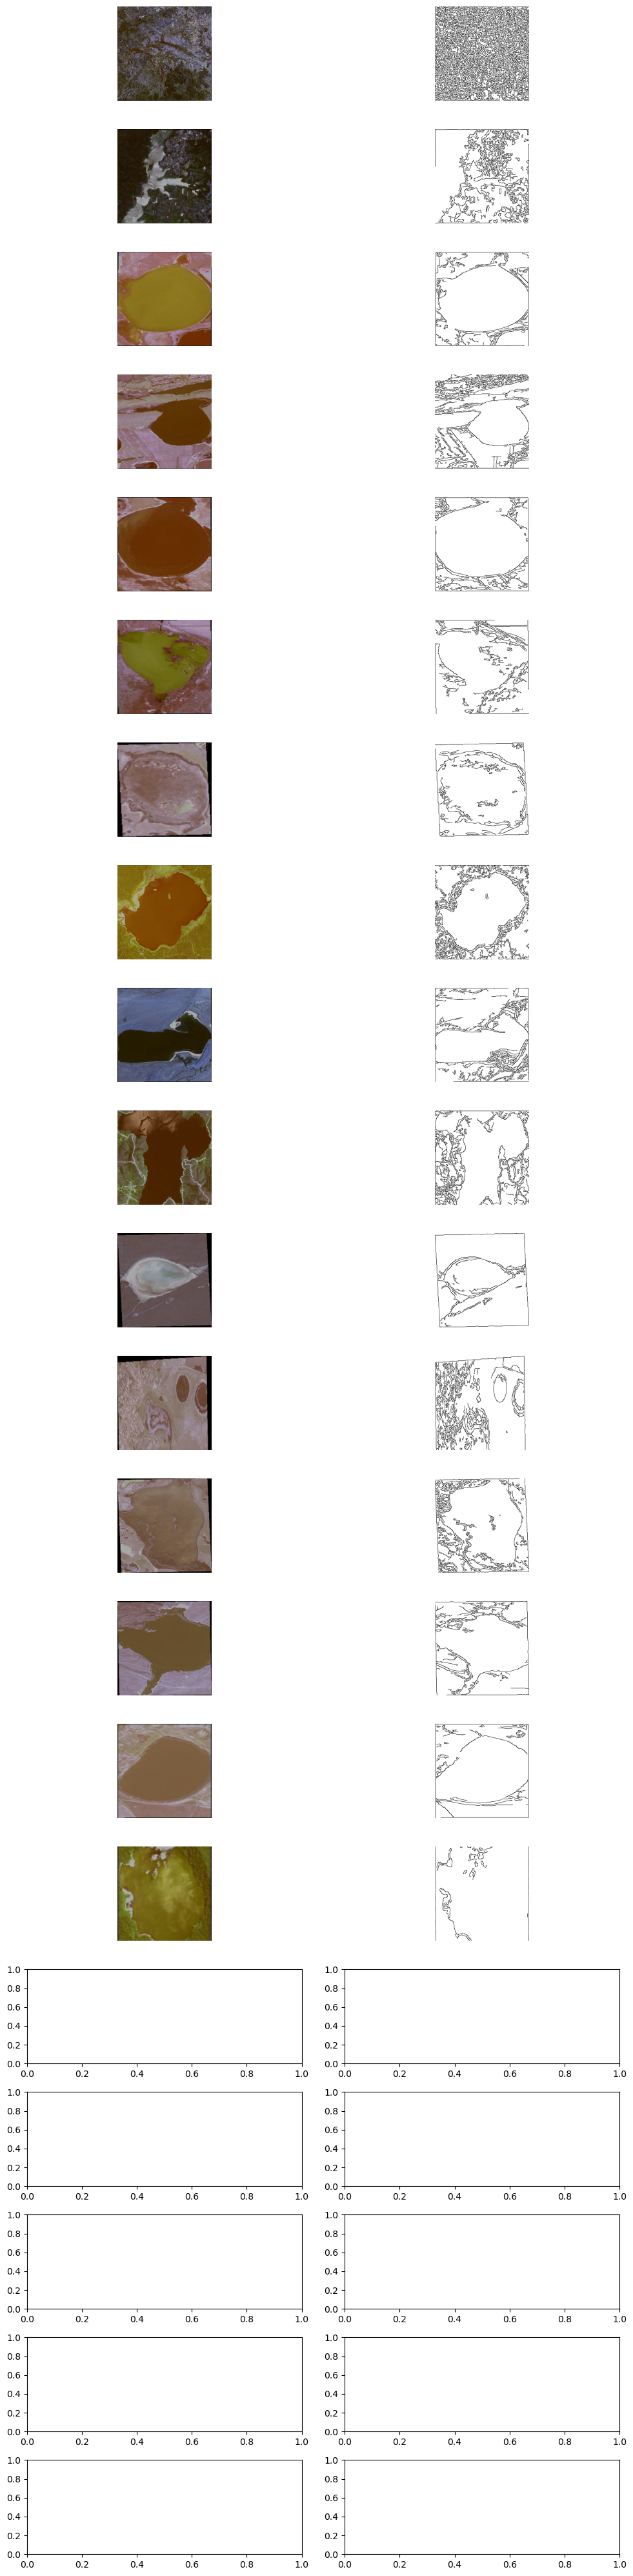

In [4]:
import matplotlib.pyplot as plt

def feature_segmentation(images, low_threshold=50, high_threshold=150, invert=True):
    segmented_masks = []
    for image in images:
        # Применяем детекцию краев с использованием метода Кэнни
        edges = cv2.Canny(image, low_threshold, high_threshold)
        
        # Преобразование краев в бинарную маску
        _, binary_mask = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)
        
        if invert:
            binary_mask = cv2.bitwise_not(binary_mask)  # Инверсия бинарной маски
        
        segmented_masks.append(binary_mask)
    
    return segmented_masks


segmented_images = feature_segmentation(all_resized_imgs)


fig, axes = plt.subplots(21, 2, figsize=(10, 40))

for ax in axes.flat:
    ax.set_aspect('auto')

for i in range(16):
    axes[i, 0].imshow(all_resized_imgs[i])
    axes[i, 0].axis('off')


for i in range(16):
    #pred_masks[i] = pred_masks[i].squeeze()
    axes[i, 1].imshow(segmented_images[i], cmap='gray')
    axes[i, 1].axis('off')

plt.tight_layout()  
plt.show()

In [5]:
def calculate_accuracy(original_masks, predicted_masks):
    accuracies = []
    for original_mask, predicted_mask in zip(original_masks, predicted_masks):
        # Преобразование масок в одноканальные бинарные маски (0 или 1)
        original_binary_mask = (original_mask > 0).astype(int)
        predicted_binary_mask = (predicted_mask > 0).astype(int)
        accuracy = np.mean(original_binary_mask == predicted_binary_mask)
        accuracies.append(accuracy)

    return accuracies

def dice_coefficient(original_mask, predicted_mask):
    # Преобразование масок в бинарные маски (0 или 1)
    original_binary_mask = (np.array(original_mask) > 0).astype(int)
    predicted_binary_mask = (np.array(predicted_mask) > 0).astype(int)

    # Вычисление коэффициента Дайса
    intersection = np.sum(original_binary_mask * predicted_binary_mask)
    union = np.sum(original_binary_mask) + np.sum(predicted_binary_mask)

    dice = (2.0 * intersection) / (union + 1e-8)  # Добавляем 1e-8, чтобы избежать деления на ноль

    return dice

def calculate_iou(original_mask, predicted_mask):
    # Преобразование масок в бинарные маски (0 или 1)
    original_binary_mask = (np.array(original_mask) > 0).astype(int)
    predicted_binary_mask = (np.array(predicted_mask) > 0).astype(int)

    # Вычисление площади пересечения и объединения масок
    intersection = np.logical_and(original_binary_mask, predicted_binary_mask)
    union = np.logical_or(original_binary_mask, predicted_binary_mask)

    iou = np.sum(intersection) / (np.sum(union) + 1e-8)  # Добавляем 1e-8, чтобы избежать деления на ноль

    return iou

acc = calculate_accuracy(all_resized_masks, segmented_images)
dice_score = dice_coefficient(all_resized_masks, segmented_images)
iou = calculate_iou(all_resized_masks, segmented_images)


print('На тестовых данных')
print('Средняя точность: ',np.mean(acc))
print('Макс. точность: ',max(acc))
print('Мин. точность: ',min(acc))
print('Dice coef: ', dice_score)
print('IOU coef: ', iou)

На тестовых данных
Средняя точность:  0.5689249038696289
Макс. точность:  0.7953643798828125
Мин. точность:  0.3087310791015625
Dice coef:  0.701762905419087
IOU coef:  0.5405506500687571
